In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ULMFit Paper:
https://arxiv.org/abs/1801.06146 \
Main Idea:
- To use finetuning of pretrained LM trained on large corpus of text and fine tune it to our selective domain of texts
- This helps model to understand the text in our target domain more easier which can be used to fine tune again to achieve our final goal
- Final goal may be text classification - Sentimental Analysis, Author Identification, Court discoveries etc.

## Dataset Used
- IMDb Review Dataset containing few thousands of movie reviews
- Contains 25k Training and 25k for testing.
- Contains seperate folder for negative and positive reviews in each training and testing folders.

# Using Highlevel API to fine tune a pretrained model directly to IMDb sentiment classifier

In [2]:
from fastai.text.all import *

In [3]:
imdbPath = untar_data(URLs.IMDB)
imdbPath.ls()

(#7) [Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/tmp_clas')]

In [4]:
(imdbPath/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/labeledBow.feat'),Path('/root/.fastai/data/imdb/train/pos')]

In [5]:
dls = TextDataLoaders.from_folder(imdbPath, valid='test')

In [6]:
dls.show_batch()

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj warning : xxmaj does contain spoilers . \n\n xxmaj open xxmaj your xxmaj eyes \n\n xxmaj if you have not seen this film and plan on doing so , just stop reading here and take my word for it . xxmaj you have to see this film . i have seen it four times so far and i still have n't made up my mind as to what exactly happened in the film . xxmaj that is all i am going to say because if you have not seen this film , then stop reading right now . \n\n xxmaj if you are still reading then i am going to pose some questions to you and maybe if anyone has any answers you can email me and let me know what you think . \n\n i remember my xxmaj grade 11 xxmaj english teacher quite well . xxmaj",pos
2,"xxbos xxmaj okay , so xxmaj i 'm not a big video game buff , but was the game xxmaj house of the xxmaj dead really famous enough to make a movie from ? xxmaj sure , they went as far as to actually put in quick video game clips throughout the movie , as though justifying any particular scene of violence , but there are dozens and dozens of games that look exactly the same , with the hand in the bottom on the screen , supposedly your own , holding whatever weapon and goo - ing all kinds of aliens or walking dead or snipers or whatever the case may be . \n\n xxmaj it 's an interesting premise in xxmaj house of the xxmaj dead , with a lot of college kids ( loaded college kids , as it were , kids who are able to pay",neg
3,"xxbos xxmaj the premise of this movie has been tickling my imagination for quite some time now . xxmaj we 've all heard or read about it in some kind of con - text . xxmaj what would you do if you were all alone in the world ? xxmaj what would you do if the entire world suddenly disappeared in front of your eyes ? xxmaj in fact , the last part is actually what happens to xxmaj dave and xxmaj andrew , two room - mates living in a run - down house in the middle of a freeway system . xxmaj andrew is a nervous wreck to say the least and xxmaj dave is considered being one of the biggest losers of society . xxmaj that alone is the main reason to why these two guys get so well along , because they simply only have each",pos
4,"xxbos xxmaj director xxmaj douglas xxmaj sirk once said ` there 's a very short distance between high art and trash , and trash that contains craziness is by this very quality nearer to art ' . xxmaj this statement defines his cinema perfectly , a very unique body of work that includes classic stage adaptations , adventure and war films , westerns and of course , his famous melodramas . \n\n xxmaj sirk 's melodramas were , as the very word signifies , dramas with music . xxmaj the music sets the tone for his masterful style , and every stroke of his brush ( sirk was also a painter ) leaves a powerful image on the screen - turned - canvas . xxmaj but this ai n't life but its representation , an imitation of life . xxmaj sirk never tried to show reality , on the contrary",pos
5,"xxbos xxmaj chris xxmaj rock deserves better than he gives himself in "" down xxmaj to xxmaj earth . "" xxmaj as directed by brothers xxmaj chris & xxmaj paul xxmaj weitz of "" american xxmaj pie "" fame , 

xxbos and xxmaj are added during tokenization so that it help the model identify the 'beginning of the string' and 'captialization of the next word

In [7]:
reviewLearner  = text_classifier_learner(dls, AWD_LSTM, drop_mult = 0.5, metrics = accuracy)

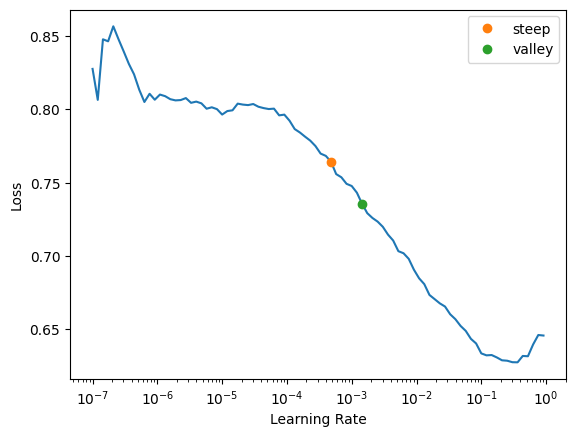

In [8]:
lr = reviewLearner.lr_find(suggest_funcs = (steep, valley))

In [9]:
reviewLearner.fine_tune(5, lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.456287,0.388044,0.825080,02:11


epoch,train_loss,valid_loss,accuracy,time
0,0.373429,0.298217,0.875880,04:05
1,0.320478,0.270474,0.887440,04:05
2,0.294620,0.238898,0.903000,04:05
3,0.270932,0.232266,0.907400,04:05
4,0.234283,0.226021,0.910640,04:05


In [10]:
reviewLearner.show_results()

,text,category,category_
0,"xxbos xxmaj there 's a sign on xxmaj the xxmaj lost xxmaj highway that says : \n\n * major xxup spoilers xxup ahead * \n\n ( but you already knew that , did n't you ? ) \n\n xxmaj since there 's a great deal of people that apparently did not get the point of this movie , xxmaj i 'd like to contribute my interpretation of why the plot makes perfect sense . xxmaj as others have pointed out , one single viewing of this movie is not sufficient . xxmaj if you have the xxup dvd of xxup md , you can "" cheat "" by looking at xxmaj david xxmaj lynch 's "" top 10 xxmaj hints to xxmaj unlocking xxup md "" ( but only upon second or third viewing , please . ) ;) \n\n xxmaj first of all , xxmaj mulholland xxmaj drive is",pos,pos
1,"xxbos xxmaj wrestlemania 6 , is an entertaining xxmaj wrestlemania , if not an entirely successful one . xxmaj the xxmaj ultimate xxmaj challenge , is of course worth the price of admission alone , but once again as with a lot of the early xxmaj mania 's , there 's too much filler in between . xxmaj the crowd pops for almost everything , and as always , giving us the reliable announcing team of xxunk xxmaj body . xxmaj having a xxmaj face vs xxmaj face match as the main event for a xxmaj wrestlemania , was absolutely unheard of at this time , it only made things that much more tense . \n\n xxmaj matches . \n\n xxmaj koko xxup b. xxmaj ware / w xxmaj frankie xxmaj vs "" the xxmaj model "" xxmaj rick xxmaj martel . xxmaj for a 3 or so minute match",pos,pos
2,"xxbos i remember vacationing in xxmaj florida when this movie aired . i had set up my xxup vcr to record it . xxmaj the anticipation was killing me . i had known about the movie ever since it was announced some half a year earlier . xxmaj we came back from xxmaj florida 4 days after the movie aired , and i immediately watched it . i tried as hard as i could to like it , but i did n't . \n\n i am a xxup huge 3 stooges fan . xxmaj and as such i know quite a bit about them . xxmaj so it was n't like i was expecting to learn anything from the movie , and i did n't . i was more interested with the portrayals and seeing how accurate their information was . xxmaj there were many things wrong with this film",neg,neg
3,"xxbos "" empire xxmaj strikes xxmaj back "" director xxmaj irvin xxmaj kershner 's "" never xxmaj say xxmaj never xxmaj again , "" a remake of the 1965 xxmaj james xxmaj bond movie "" thunderball , "" does n't surpasses the xxmaj terence xxmaj young original , but this non - harry xxmaj xxunk & xxmaj albert xxup r. xxmaj broccoli film is well worth watching if you call yourself a 007 aficionado . xxmaj nevertheless , despite its shortage of clever gadgets and the lack of a vibrant musical score , "" never xxmaj say xxmaj never xxmaj again "" rates as an above - average , suspenseful doomsday thriller with top - flight performances by a seasoned cast including xxmaj sean xxmaj connery , xxmaj kim xxmaj basinger , xxmaj klaus xxmaj maria xxmaj brandauer , xxmaj max xxmaj von xxmaj sydow , xxmaj barbara xxmaj carrera",pos,neg
4,"xxbos i was recently given this film on xxup dvd as a gift , and was unsure at first if it would appeal ( although one of my favourite actors has a leading role ) . xxmaj in fact , it 's on its way to becoming a favourite . \n\n xxmaj first of all : thankfully , it 's * not * the same as the book , the ending of which i think is excessively melodramatic . xxmaj secondly : it 's one of the best films xxmaj i 've seen about the xxmaj first xxmaj world xxmaj war . "" what ? "" you may ask . "" it 's not a war film ! "" xxmaj true : we see no battles or xxunk , no trenches , no gas . xxmaj but it shows the cost of war , the damage done to the lives",pos,pos
5,"xxbos xxmaj it has been widely agreed that xxmaj hayao xxmaj miyazaki is a master at his craft when it comes to combining rich animation with thoughtful story lines and similarly imaginative characters . xxmaj his movies , from xxup nausicaa , xxup to

In [11]:
reviewLearner.predict('I really didn\'t like the movie')

('neg', tensor(0), tensor([0.5802, 0.4198]))

# The ULMFiT Approach
Since the AWD_LSTM pretrained model has been trained with wikipedia english which is different that the english used in the IMDB reviews we will be taking two step approach to create a classifier
### Steps:
1. Turn wiki language model into IMDb language model We will use the non categorised additional text dataset supplied to create IMDb Language model
2. Turn the IMDb Language model into review classifier Fine tune the model to classifier using the labelled dataset


## Step 1: Finetuning to create IMDb Review LM

In [12]:
# is_lm parameter sets the dataloaders object to have labels according to the LM
dls_lm = TextDataLoaders.from_folder(imdbPath, is_lm=True, valid_pct=0.1)

In [13]:
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos xxup evan xxup almighty ( 2007 ) * * xxmaj steve xxmaj carell , xxmaj morgan xxmaj freeman , xxmaj lauren xxmaj graham , xxmaj johnny xxmaj simmons , xxmaj graham xxmaj phillips , xxmaj jimmy xxmaj bennett , xxmaj john xxmaj goodman , xxmaj wanda xxmaj sykes , xxmaj john xxmaj michael xxmaj higgins , xxmaj jonah xxmaj hill , xxmaj molly xxmaj shannon , xxmaj ed xxmaj helms ,","xxup evan xxup almighty ( 2007 ) * * xxmaj steve xxmaj carell , xxmaj morgan xxmaj freeman , xxmaj lauren xxmaj graham , xxmaj johnny xxmaj simmons , xxmaj graham xxmaj phillips , xxmaj jimmy xxmaj bennett , xxmaj john xxmaj goodman , xxmaj wanda xxmaj sykes , xxmaj john xxmaj michael xxmaj higgins , xxmaj jonah xxmaj hill , xxmaj molly xxmaj shannon , xxmaj ed xxmaj helms , ("
1,"movie . \n\n xxmaj john xxmaj carpenter took a low budget film and he scared a generation of movie goers . xxmaj he showed that you do n't need budgets in the 8 or 9 figures to evoke fear on an audience . xxmaj because sometimes the best element of fear is not what actually happens , but what is about to happen . xxmaj what was that shadow ? xxmaj what",". \n\n xxmaj john xxmaj carpenter took a low budget film and he scared a generation of movie goers . xxmaj he showed that you do n't need budgets in the 8 or 9 figures to evoke fear on an audience . xxmaj because sometimes the best element of fear is not what actually happens , but what is about to happen . xxmaj what was that shadow ? xxmaj what was"
2,"is good in his role i liked him . xxmaj lincoln xxmaj kilpatrick had a strong presence about him and was great as xxmaj abraham , it sucked he did n't survive . xxmaj jeffrey xxmaj combs is good as the computer geek i love this guy ! . xxmaj rest of the cast are fine . \n\n xxmaj overall i highly recommend this one ! . xxrep 3 * 1 /","good in his role i liked him . xxmaj lincoln xxmaj kilpatrick had a strong presence about him and was great as xxmaj abraham , it sucked he did n't survive . xxmaj jeffrey xxmaj combs is good as the computer geek i love this guy ! . xxmaj rest of the cast are fine . \n\n xxmaj overall i highly recommend this one ! . xxrep 3 * 1 / 2"
3,"( both picture and xxunk existing copies . xxmaj insulting racial stereotyping . ( as implied above . ) \n\n xxmaj ridiculously inaccurate scientific predictions about television . ( as implied above . ) \n\n xxmaj undeveloped characters , giving the audience a "" who cares "" feeling when someone gets murdered . \n\n xxmaj and a general weakness of the writing , acting , and directing . \n\n xxmaj being a","both picture and xxunk existing copies . xxmaj insulting racial stereotyping . ( as implied above . ) \n\n xxmaj ridiculously inaccurate scientific predictions about television . ( as implied above . ) \n\n xxmaj undeveloped characters , giving the audience a "" who cares "" feeling when someone gets murdered . \n\n xxmaj and a general weakness of the writing , acting , and directing . \n\n xxmaj being a xxmaj"
4,"stereotype : gorgeously grotesque xxup d.j . xxmaj qualls as computer - hacker , xxmaj rat . xxmaj is n't his "" unlikely hero "" character one of those rootless , amoral beings who make our modern online lives unbearable with viruses and identity theft and their wholly unnecessary existence ? xxmaj the sooner they are eradicated , rather than xxunk , the better . \n\n xxmaj there 's the square -",": gorgeously grotesque xxup d.j . xxmaj qualls as computer - hacker , xxmaj rat . xxmaj is n't his "" unlikely hero "" character one of those rootless , amoral beings who make our modern online lives unbearable with viruses and identity theft and their wholly unnecessary existence ? xxmaj the sooner they are eradicated , rather than xxunk , the better . \n\n xxmaj there 's the square - jawed"


In [14]:
# Grabbing learner 
# Setting our dataloaders
# setting our base pretrained model architechture
# setting metrics and weight decay
# .to_fp16puts the learner in mixed precision which drops some 
# decimal precision to get faster on the GPUs which contain tensor cores
learn = language_model_learner(dls_lm,
                               AWD_LSTM,
                               metrics = [accuracy, Perplexity()],
                               path=imdbPath,
                               wd=0.1).to_fp16()

we are using slanting learning rate hence lr is different in last layer and in hidden layers

In [15]:
# By default model is in frozen_state
# ie, model head will train and rest of the body stays frozen
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.402109,4.115086,0.286326,61.257458,31:37


Saving and loading intermediate results

In [16]:
learn.save('1epoch')
# Saved at learn.path/models/

Path('/root/.fastai/data/imdb/models/1epoch.pth')

In [17]:
learn = learn.load('1epoch')

In [18]:
# Unfreezing the entire model
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.034254,3.837670,0.313056,46.417210,34:51


we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary.

In [19]:
# Saving the model without the final layer (encoder) which determines the outcome of the final goal/task of the model
learn.save_encoder('finetuned')

Since our IMDb dataset based Language model has been created; we can use it to predict the next words of the random movie reviews....
Since it is trained to guess the next word of the sentence specifically movie reviews

In [20]:
TEXT = 'I like this movie because of scene where'
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]
print('\n'.join(preds))

i like this movie because of scene where Barbara Stanwyck goes on the plane and sees a chick . All the actors are pretty good . The plot is n't as bad as it is . The plot is contrived , the actors
i like this movie because of scene where Jack Black and Jack Black are in a car crash . They get hit by the car and start driving . They do n't know what it 's about , dani there 's a


## Step 2: Finetuning IMDb Language Model to Review Classifier

In [21]:
# We are adding the vocabulary used in dls_lm 
# Or the weight learned from finetuning to IMDb Language Model won't be of any use

dls_clas = TextDataLoaders.from_folder(imdbPath,
                           valid='test',
                           text_vocab = dls_lm.vocab)

In [22]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [23]:
# The difference is that before training it, we load the previous encoder:
learn = learn.load_encoder('finetuned')

Last step is to train with discriminative learning rates and gradual unfreezing. In computer vision, we oftten unfreeze the model all at once, but for NLP classifiers, we would unfreeze few layers at a time...This makes a real difference and prevents loss of information the data that model was trained on earlier

In [24]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.280097,0.243641,0.903320,02:11


In just one epoch we get the same result as our training in the first section, not too bad! We can pass -2 to freeze_to to freeze all except the last two parameter groups:

In [25]:
# unfreeze last two layers
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.239275,0.189365,0.927840,02:29


In [26]:
# Unfreezing more
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.202637,0.169201,0.936920,03:22


In [27]:
# Unfreeze all
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.170342,0.164861,0.938320,04:07


## Predicting the sentiment (classification) 

In [28]:
learn.predict('I really didn\'t like the movie')

('pos', tensor(1), tensor([0.0995, 0.9005]))

In [29]:
learn.predict('I think the movie was boring')

('pos', tensor(1), tensor([0.2946, 0.7054]))

In [30]:
learn.predict('I feel that movie could have been wrote better')

('neg', tensor(0), tensor([0.5161, 0.4839]))

In [31]:
learn.predict('I loved the movie!')

('pos', tensor(1), tensor([8.2578e-05, 9.9992e-01]))